# Simulation Code

In [2]:
%load_ext Cython
%matplotlib inline

In [14]:
%%cython

# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

import numpy as np
from tqdm import tqdm
import argparse
from multiprocessing import cpu_count
from functools import partial
from multiprocessing.pool import Pool
import pandas as pd
cimport numpy as np

def graphing_function(np.ndarray[np.float64_t, ndim=1] infected_pop_norm, 
                      np.ndarray[np.float64_t, ndim=1] susceptible_pop_norm, 
                      np.ndarray[np.float64_t, ndim=1] recovered_pop_norm, 
                      np.ndarray[np.float64_t, ndim=1] public_trans_vec, 
                      int days, 
                      fig_name,
                      plot_title):
    import matplotlib.pyplot as plt
    # plot results and save the plot
    fig = plt.figure()
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.plot(np.arange(days), susceptible_pop_norm, label='Susceptible', color='#4aa5f0', linewidth=2)
    ax.plot(np.arange(days), infected_pop_norm, label='Infected', color='#f03737', linewidth=2)
    ax.plot(np.arange(days), recovered_pop_norm, label='Recovered', color='#82e88a', linewidth=2)
    ax.plot(np.arange(days), public_trans_vec, '--', label='Transit Intensity', color='k', linewidth=2)
    ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))
    ax.set_xlabel("Days")
    ax.set_ylabel("Share of Population")
    plot_title = plot_title.replace('_',' ').replace('[','').replace(']','').replace("'",'')
    plt.title(plot_title)
    if fig_name:
        ax.figure.savefig('figures/' + fig_name + '.png')
    else:
        ax.figure.savefig('figures/sir_plot.png')
    plt.show()
    plt.close()
    
# Convenience function: access Python dict keys as dict.key instead of dict['key']
class objdict(dict):
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError("No such attribute: " + name)
            
# Run n simulations in parallel: for each run, parameters are randomly sampled from an interval
# NOTE: Are these intervals reasonable?
def multiprocess(args):

    chunks = []
    num_procs = args.randomize
    for _ in range(num_procs):
        d = dict()
        d['origin_matrix_path'] = args.origin_matrix_path
        d['thresh1'] = np.random.randint(0, 350)
        d['thresh2'] = np.random.randint(d['thresh1'], 700)
        d['infect_pct'] = float(args.infect_pct)
        d['beta'] = args.beta
        d['gamma'] = args.gamma
        d['public_trans'] = args.public_trans
        d['public_trans_vec'] = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in args.public_trans_vec])
        d['days'] = args.days
        d['fig_name'] = 'public_trans_{:0.1f}_({}, {})_inf_{}'.format(d['public_trans'], d['thresh1'], d['thresh2'], d['infection_magnitude'])
        d['plot_title'] = args.plot_title
        d['loading'] = args.loading
        d = objdict(d)
        chunks.append(d)

    with Pool(num_procs) as p:
        p.map(covid_mp_sim, chunks)

    p.join()

def covid_sim(args):
    # Read in origin-destination flow matrix  
    cdef np.ndarray[np.float64_t, ndim=2] OD, SIR, SIR_n, SIR_sim, SIR_nsim, infected_mat, OD_infected 
    cdef np.ndarray[np.float64_t, ndim=1] N_k, first_infections, row_sums, beta_vec, gamma_vec, inflow_infected, new_infect, new_recovered
    cdef int locs_len, time_step
    cdef np.float64_t R0, S, I, R
    cdef np.ndarray[np.float64_t, ndim=1] infected_pop_norm, susceptible_pop_norm, recovered_pop_norm

    if args.loading != 0:
        OD = pd.read_csv('data/nyc_od.csv', header=None, dtype=np.float64).to_numpy()
    else:
        OD = np.genfromtxt(args.origin_matrix_path, delimiter=',')

    # initialize the population vector from the origin-destination flow matrix
    N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
    locs_len = len(N_k)                 # number of locations
    SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
    SIR[:,0] = N_k                      # initialize the S group with the respective populations
    thresh1 = args.thresh1
    thresh2 = args.thresh2
    first_infections = np.where((thresh1 <= SIR[:, 0]) & (SIR[:, 0] <= thresh2), np.floor(args.infect_pct*SIR[:,0]), 0).astype(np.float64)
    SIR[:, 0] = SIR[:, 0] - first_infections                           # remove infections from S group
    SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group
    
    # row normalize the SIR matrix for keeping track of group proportions
    row_sums = SIR.sum(axis=1)
    SIR_n = SIR / row_sums[:, np.newaxis]

    # initialize parameters
    beta = args.beta
    gamma = args.gamma
    public_trans = args.public_trans                                 # alpha
    R0 = beta/gamma
    beta_vec = np.random.gamma(beta, 2, locs_len)
    gamma_vec = np.full(locs_len, gamma)
    public_trans_vec = args.public_trans_vec
    if isinstance(public_trans_vec[0], str):
        public_trans_vec = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in public_trans_vec])
    fig_name = args.fig_name
    plot_title = str(args.plot_title)
    
    # make copy of the SIR matrices 
    SIR_sim = SIR.copy()
    SIR_nsim = SIR_n.copy()

    # run model
    #print(SIR_sim.sum(axis=0).sum() == N_k.sum())
    days = args.days
    infected_pop_norm = np.zeros(days)
    susceptible_pop_norm = np.zeros(days)
    recovered_pop_norm = np.zeros(days)
    for time_step in range(days):
        infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
        OD_infected = np.round(OD*infected_mat)
        inflow_infected = OD_infected.sum(axis=0)
        inflow_infected = np.round(inflow_infected*public_trans_vec[time_step])
        #print('total infected inflow: ', inflow_infected.sum())
        new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
        new_recovered = gamma_vec*SIR_sim[:, 1]
        new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
        SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
        SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
        SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
        SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
        # recompute the normalized SIR matrix
        row_sums = SIR_sim.sum(axis=1)
        SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
        S = SIR_sim[:,0].sum()/N_k.sum()
        I = SIR_sim[:,1].sum()/N_k.sum()
        R = SIR_sim[:,2].sum()/N_k.sum()
        #print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
        #print('\n')
        infected_pop_norm[time_step] = I 
        susceptible_pop_norm[time_step] = S 
        recovered_pop_norm[time_step] = R
        
    graphing_function(infected_pop_norm, susceptible_pop_norm, recovered_pop_norm, public_trans_vec, days, fig_name, plot_title)
    
def covid_mp_sim(args):
    # Read in origin-destination flow matrix  
    cdef np.ndarray[np.float64_t, ndim=2] OD, SIR, SIR_n, SIR_sim, SIR_nsim, infected_mat, OD_infected 
    cdef np.ndarray[np.float64_t, ndim=1] N_k, first_infections, row_sums, beta_vec, gamma_vec, inflow_infected, new_infect, new_recovered, public_trans_vec
    cdef int locs_len, time_step
    cdef np.float64_t R0, S, I, R
    cdef np.ndarray[np.float64_t, ndim=1] infected_pop_norm, susceptible_pop_norm, recovered_pop_norm 

    if args.loading != 0:
        OD = pd.read_csv('data/nyc_OD.csv', header=None, dtype=np.float64).to_numpy()
    else:
        OD = np.genfromtxt(args.origin_matrix_path, delimiter=',')

    # initialize the population vector from the origin-destination flow matrix
    N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
    locs_len = len(N_k)                 # number of locations
    SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
    SIR[:,0] = N_k                      # initialize the S group with the respective populations
    thresh1 = args.thresh1
    thresh2 = args.thresh2
#     first_infections = np.where((thresh1 <= SIR[:, 0]) & (SIR[:, 0] <= thresh2), np.random.randint(1, args.infection_magnitude), 0).astype(np.float64)   # for demo purposes, randomly introduce infections
    first_infections = np.where((thresh1 <= SIR[:, 0]) & (SIR[:, 0] <= thresh2), np.floor(args.infect_pct*SIR[:,0]), 0).astype(np.float64)
    # NOTE: this is arbitrary but not actually random.... 
    SIR[:, 0] = SIR[:, 0] - first_infections
    SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group
    
    # row normalize the SIR matrix for keeping track of group proportions
    row_sums = SIR.sum(axis=1)
    SIR_n = SIR / row_sums[:, np.newaxis]

    # initialize parameters
    beta = args.beta
    gamma = args.gamma
    public_trans = args.public_trans                                 # alpha
    R0 = beta/gamma
    beta_vec = np.random.gamma(beta, 2, locs_len)
    gamma_vec = np.full(locs_len, gamma)
    public_trans_vec = args.public_trans_vec
#     if isinstance(public_trans_vec[0], str):
#         public_trans_vec = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in public_trans_vec])
    fig_name = args.fig_name
    plot_title = args.plot_title

    # make copy of the SIR matrices 
    SIR_sim = SIR.copy()
    SIR_nsim = SIR_n.copy()

    # run model
    #print(SIR_sim.sum(axis=0).sum() == N_k.sum())
    days = args.days
    infected_pop_norm = np.zeros(days)
    susceptible_pop_norm = np.zeros(days)
    recovered_pop_norm = np.zeros(days)
    for time_step in tqdm(range(days)):
        infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
        OD_infected = np.round(OD*infected_mat)
        inflow_infected = OD_infected.sum(axis=0)
        inflow_infected = np.round(inflow_infected*public_trans_vec[time_step])
        #print('total infected inflow: ', inflow_infected.sum())
        new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
        new_recovered = gamma_vec*SIR_sim[:, 1]
        new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
        SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
        SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
        SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
        SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
        # recompute the normalized SIR matrix
        row_sums = SIR_sim.sum(axis=1)
        SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
        S = SIR_sim[:,0].sum()/N_k.sum()
        I = SIR_sim[:,1].sum()/N_k.sum()
        R = SIR_sim[:,2].sum()/N_k.sum()
        #print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
        #print('\n')
        infected_pop_norm[time_step] = I 
        susceptible_pop_norm[time_step] = S 
        recovered_pop_norm[time_step] = R

    graphing_function(infected_pop_norm, susceptible_pop_norm, recovered_pop_norm, public_trans_vec, days, fig_name, plot_title)

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate

def generate_ptv(public_trans=0.56, days=100, earlier_start=0, earlier_decline=0, earlier_bottom=0, low_val=0.07, reopen_day=88, reopen_val=0.07, scenario=1):
    '''
    Function to generate transit intensity vector with user-specified conditions.
    
    Parameters
    ----------
    public_trans (float): 
        Baseline % of population using public transit before the pandemic. Defaults to 0.56.
    days (int):
        Number of days to run simulation for. Defaults to 100.
    earlier_start (int): 
        Number of days prior to Feb 22nd to begin the simulation. This allows for the possibility of infections to have been introduced earlier than 
        what is known. Feb 22nd is 5 days before the first confirmed patient's symptoms began--the estimated date of their infection. Defaults to 0.
    earlier_decline (int): 
        Number of days prior to March 7th to set for the start of transit-decline. March 7th is when a state of emergency was declared in NY. Defaults to 0.
    earlier_bottom (int): 
        Number of days prior to April 8th to set for the minimum transit intensity. On April 8th the MTA reported that ridership had fallen by 93%.
        This controls the steepness of the decline. Defaults to 0.
    low_val (float):
        The lowest percentage of typical ridership to decrease transit values to. Defaults to 0.07, as reported by the MTA.
    reopen_day (int):
        The day to designate for transit beginning to increase. Defaults to 88--which corresponds to May 15th--the day that the current travel restrictions will expire. 
    reopen_val (float):
        The value to increase transit intensity to when travel restrictions end. Defaults to 0.07, which represents transit restrictions being renewed.
    scenario (int):
        Value to indicate different sets of conditions for generating the transit values. Value of '1' generates values in which transit stays constant, 
        '2' generates declining transit values, and '3' generates values that decline and eventually increase. Defaults to 1. 
        
    Returns
    ----------
    public_trans_vec (ndarray of np.float64): 
        Vector of transit intensity values rounded to 2 decimal places.
    '''  
    
    # scenario 1: constant transit
    if scenario == 1:
        public_trans_vec = np.full(days, public_trans)
    
    # scenario 2: transit decreases and stays low
    elif scenario == 2:
        x = [19+earlier_start-earlier_decline, 29+earlier_start-earlier_decline, 51-earlier_bottom+earlier_start-earlier_decline]
        y = [1, .4, low_val]
        f = interpolate.interp1d(x, y)
        # append values for days before and after periods of decreasing ridership
        ridership = np.append(np.ones(18+earlier_start-earlier_decline), f(np.arange(19+earlier_start-earlier_decline,52-earlier_bottom+earlier_start-earlier_decline)))
        ridership = np.append(ridership, np.full(days-len(ridership), low_val))
        # multiply ridership by public_trans to get public_trans_vec, append to reopen_vals
        public_trans_vec = ridership * public_trans
          
    # scenario 3: transit decreases and then increases
    elif scenario == 3:
        x = [19+earlier_start-earlier_decline, 29+earlier_start-earlier_decline, 51+earlier_start-earlier_decline, 60+earlier_start-earlier_decline]
        y = [public_trans, public_trans*.4, public_trans*.08, public_trans*low_val]
        f = interpolate.interp1d(x, y)
        # append values for days before and after periods of decreasing ridership
        ridership = np.append(public_trans*np.ones(18+earlier_start-earlier_decline), f(np.arange(19+earlier_start-earlier_decline,61+earlier_start-earlier_decline)))
        ridership = np.append(ridership, np.full(days-len(ridership), reopen_val))
        # multiply ridership by public_trans to get public_trans_vec, append to reopen_vals
#         public_trans_vec = ridership * public_trans
        public_trans_vec = ridership
    
    return np.around(public_trans_vec, 2)

# def generate_log_ptv(t, k=.55, start_ptv=.56, inflection=27, end_ptv=0.04):
#     def log_ptv(t, k=.55, start_ptv=.56, inflection=27, end_ptv=0.04):
#         return (start_ptv-end_ptv) / (1 + np.exp(-k*(-t+inflection))) + end_ptv

#     t = np.linspace(0, 60, 60)
#     # r1 = [logistic_R_0(t, 0.5, 29) for t in range(1,101)]
#     log_ptv = [gen_log_ptv(i, start_ptv=1, end_ptv=0.07) for i in range(len(t))]

def gen_log_ptv(days=100, k=.4, start_ptv=.56, inflection=28, end_ptv=0.04, plot=False):
    log_ptv = [(start_ptv-end_ptv) / (1 + np.exp(-k*(-t+inflection))) + end_ptv for t in range(days)]
    if plot:
        fig = plt.figure()
        ax = plt.axes()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.plot(np.arange(days), log_ptv, '--', label=f'k={k}', color='k', linewidth=2)
        ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))
        ax.set_xlabel("Days")
        ax.set_ylabel("transit")
        plt.show()
    return log_ptv

In [16]:
# parser
parser = argparse.ArgumentParser(description='COVID Simulator')
parser.add_argument('--randomize', type=int, default=0)
parser.add_argument('--origin-matrix-path', default='data/nyc_od.csv')
parser.add_argument('--thresh1', type=int, default=0)
parser.add_argument('--thresh2', type=int, default=200)
parser.add_argument('--infect-pct', type=float, default=0.05)
parser.add_argument('--beta', type=float, default=0.57)
parser.add_argument('--gamma', type=float, default=0.2)
parser.add_argument('--public-trans', type=float, default=0.56)
parser.add_argument('--public-trans-vec', nargs='+', default=[])
parser.add_argument('--days', type=int, default=100)
parser.add_argument('--img-folder', default='figures/')
parser.add_argument('--loading', default = 0)
parser.add_argument('--fig-name', default = 'figure_1')
parser.add_argument('--plot-title', nargs='+', type=str, default='COVID-19 Simulation')

_StoreAction(option_strings=['--plot-title'], dest='plot_title', nargs='+', const=None, default='COVID-19 Simulation', type=<class 'str'>, choices=None, help=None, metavar=None)

# Parameters

### $\beta$ (transmission rate)

Text(0.5, 1.0, 'Distribution of beta (Mean = 1.14)')

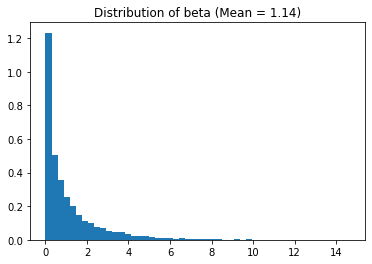

In [153]:
shape = .57
scale = 2
s = np.random.gamma(shape, scale, 10000)
import scipy.special as sps
count, bins, ignored = plt.hist(s, 50, density=True)
plt.title(f'Distribution of beta (Mean = {np.mean(s):.2f})')

### $1/\gamma$ (infectious period)
Assumed to be 5 days, with $\gamma = 0.2$

### Modal Split/Transit Intensity

The variable 'public_trans_vec' in our simulation represents the intensity of public transportation. 56% of the population of NYC is estimated to use public transportation. Thus, we initially set public_trans to 0.56. The earliest reported symptoms of a confirmed case occurred on Feb 22nd, and we estimate that the 
individual was infected 5 days prior (Feb 17th). This will mark the first day of our simulation, although 
there were likely infections prior to this date, since the infected individual did not travel anywhere 
prior to contracting the virus. NYC limited transportation of non-essential workers on March 22nd, 34 days 
later. This is reflected by lowering the public_trans value on the 34th day of the simulation. 
Reports from the MTA have stated that from February, subway ridership fell by 60% as of 
March 17th, and 92% by April 8th, and 93% by April 17th. We can use these values to estimate public_trans 
over time. <br><br>


#### Timeline
Day &emsp; Ridership <br>
1 &emsp;&emsp;&nbsp;  100% <br>
19 &emsp;&emsp;100% (March 7th -- state of emergency declared -- this is when ridership likely started falling) <br>
29 &emsp;&emsp; 40% (March 17th) <br>
51 &emsp;&emsp; 8%  (April 8th) <br>
60 &emsp;&emsp; 7%  (April 17th) <br>
88 &emsp;&emsp; 28%  (May 15th -- possible lifting of stay-at-home restrictions) <br>
<br>
Sources: <br>
https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_New_York_(state)#Timeline <br>
https://nytransit.org/resources/public-transit-facts <br>
https://comptroller.nyc.gov/reports/new-york-citys-frontline-workers/<br>
http://web.mta.info/nyct/facts/ridership/ <br>
https://www.businessinsider.com/coronavirus-nyc-subway-ridership-craters-amid-coronavirus-mta-seeks-bailout-2020-3 <br>
https://www.businessinsider.com/new-york-subway-rides-plunge-mta-requests-second-bailout-93-2020-4 <br>
https://brooklyneagle.com/articles/2020/04/08/new-york-city-subway-ridership-down-92-percent-due-to-coronavirus/

##### MTA ridership over time

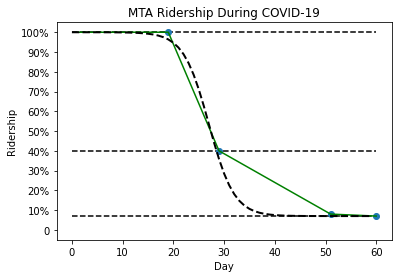

In [59]:
# approximate ridership percentages over time 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
%matplotlib inline

earlier_start = 0    # days before Feb 22 (day of Patient-0's first reported symptoms)
x = [19+earlier_start, 29+earlier_start, 51+earlier_start, 60+earlier_start]
y = [1, .4, .08, .07]
f = interp1d(x, y)
plt.plot(x, y, 'o')
plt.xlabel('Day')
plt.ylabel('Ridership')
new_y = np.append([1], f(x))
x = np.append([1], x)
plt.plot(x, new_y, 'g', '-')

# logistic curve for smoothed version:
def gen_log_ptv(t, k=.4, start_ptv=.56, inflection=28, end_ptv=0.04, reopen=False, reopen_val=.5):
    return (start_ptv-end_ptv) / (1 + np.exp(-k*(-t+inflection))) + end_ptv
t = np.linspace(0, 60, 60)
log_ptv = [gen_log_ptv(i, start_ptv=1, inflection=27, end_ptv=0.07) for i in range(len(t))]

plt.plot(np.arange(60), log_ptv, '--', label='k=0.5', color='k', linewidth=2)
plt.yticks(np.arange(0,1.1, step=0.1), ['0','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
plt.hlines([1, .4, .07], 0, 60+earlier_start, linestyles='--')
plt.title('MTA Ridership During COVID-19')
plt.savefig('figures/MTA_ridership.png')
plt.show()

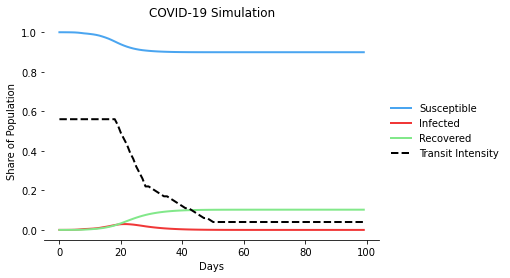

In [17]:
# trying diff beta 
ptv = generate_ptv(public_trans=0.56, low_val=0.07, scenario=2)
args2 = parser.parse_args(f'--beta 0.5 --gamma 0.2 --public-trans-vec {ptv}'.split())
covid_sim(args2)

273.0
Total Infected: 0.21688913915756852


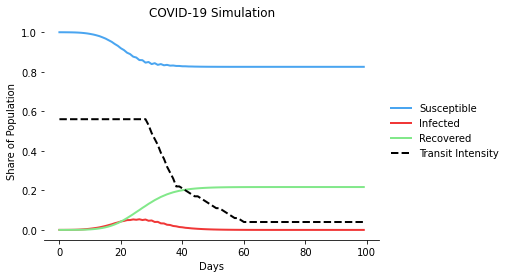

In [131]:
# beta = .6, 10 day earlier start
ptv = generate_ptv(public_trans=0.56, earlier_start=10, low_val=0.07, scenario=2)
args4 = parser.parse_args(f'--beta 0.6 --public-trans-vec {ptv}'.split())
covid_sim(args4)

273.0
Total Infected: 0.1738786281897685


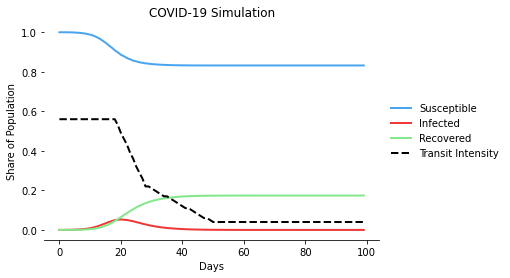

In [132]:
# beta = .6, no early start
ptv = generate_ptv(public_trans=0.56, low_val=0.07, scenario=2)
args4 = parser.parse_args(f'--beta 0.6 --public-trans-vec {ptv}'.split())
covid_sim(args4)

273.0
Total Infected: 0.24564017842670505


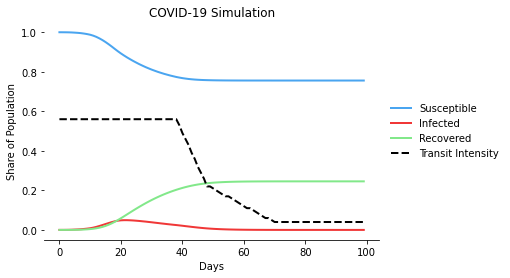

In [133]:
# beta = .57, 20 day early start
ptv = generate_ptv(public_trans=0.56, earlier_start=20, low_val=0.07, scenario=2)
args4 = parser.parse_args(f'--beta 0.57 --public-trans-vec {ptv}'.split())
covid_sim(args4)

#### testing different $\beta$-values

273.0
Total Infected: 0.32643188397517137


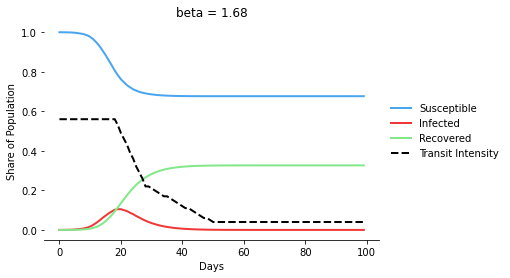

In [162]:
# beta = 0.84 (1.68 mean dist) 
ptv = generate_ptv(public_trans=0.56, low_val=0.07, scenario=2)
plot_title = 'beta_=_1.68'
args4 = parser.parse_args(f'--beta .84 --public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args4)

273.0
['beta_=_0.59']
Total Infected: 0.05253436553943418


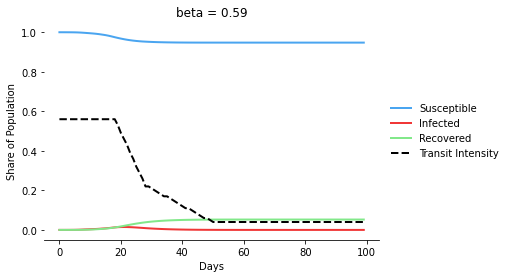

In [164]:
# beta = 0.59 
ptv = generate_ptv(public_trans=0.56, low_val=0.07, scenario=2)
plot_title = 'beta_=_0.59'
args4 = parser.parse_args(f'--beta .295 --public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args4)

## Experiments

### Experiment 1: effect of travel intensity for diff constant levels

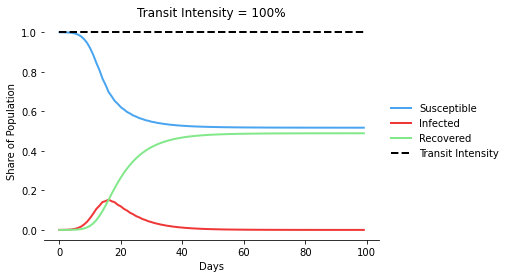

In [19]:
# constant transit at 1
ptv = generate_ptv(public_trans=1, days=100, scenario=1)
plot_title = 'Transit_Intensity_=_100%'
args1 = parser.parse_args(f'--beta 0.57 --gamma 0.2 --public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args1)

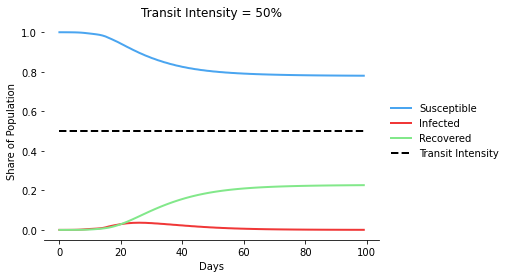

In [20]:
# constant transit at 0.50
ptv = generate_ptv(public_trans=0.50, days=100, scenario=1)
plot_title = 'Transit_Intensity_=_50%'
args1 = parser.parse_args(f'--public-trans-vec {ptv} --public-trans 0.50 --plot-title {plot_title}'.split())
covid_sim(args1)

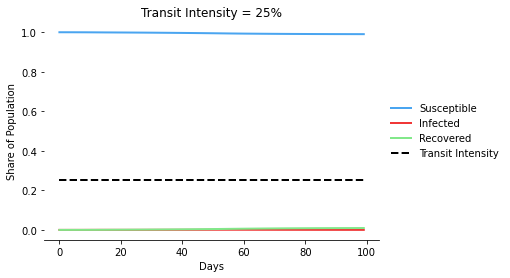

In [21]:
# constant transit at 0.25
ptv = generate_ptv(public_trans=0.25, days=100, scenario=1)
plot_title = 'Transit_Intensity_=_25%'
args1 = parser.parse_args(f'--public-trans 0.25 --public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args1)

### Experiment 2: travel decreases to different levels

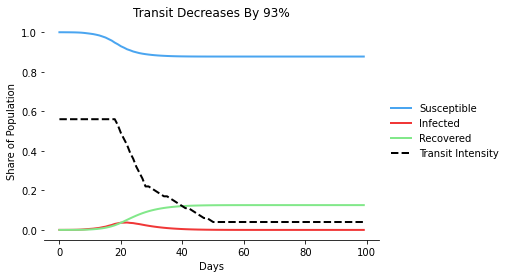

In [44]:
# transit decreases to 0.07
plot_title = 'Transit_Decreases_By_93%'
ptv = generate_ptv(public_trans=0.56, low_val=0.07, scenario=2)
args2 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args2)

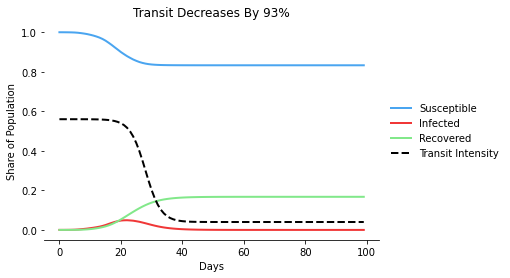

In [61]:
# transit decreases by 93%
plot_title = 'Transit_Decreases_By_93%'
ptv = gen_log_ptv()
args2 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args2)

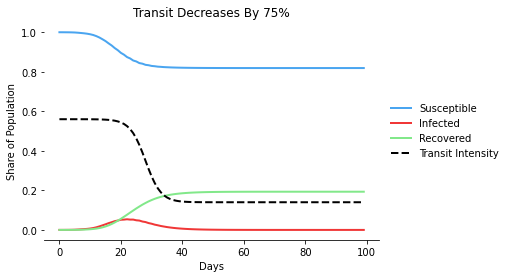

In [62]:
# transit decreases By 75%
plot_title = 'Transit_Decreases_By_75%'
ptv = gen_log_ptv(end_ptv=0.25*0.56)
args2 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args2)

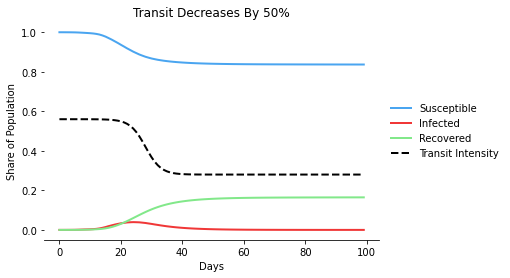

In [63]:
# transit decreases By 50%
plot_title = 'Transit_Decreases_By_50%'
ptv = gen_log_ptv(end_ptv=0.50*0.56)
args2 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args2)

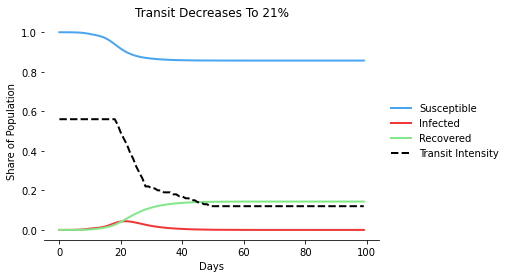

In [27]:
# transit decreases to 0.21
plot_title = 'Transit_Decreases_By_79%'
ptv = generate_ptv(public_trans=0.56, low_val=0.21, scenario=2)
args2 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args2)

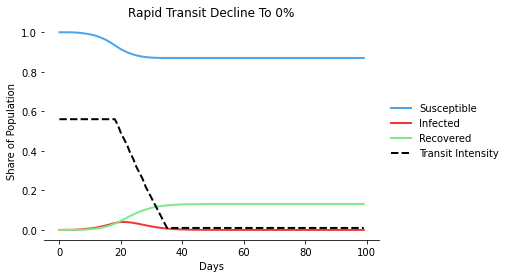

In [28]:
# transit decreases more rapidly to nearly 0
plot_title = 'Rapid_Transit_Decline_To_0%'
ptv = generate_ptv(public_trans=0.56, low_val=0.01, earlier_bottom=15, scenario=2)
args2 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args2)

### Experiment 3: effect of government reaction time

In [ ]:
def gen_log_ptv(days=100, k=.55, start_ptv=.56, inflection=27, end_ptv=0.04, plot=False)

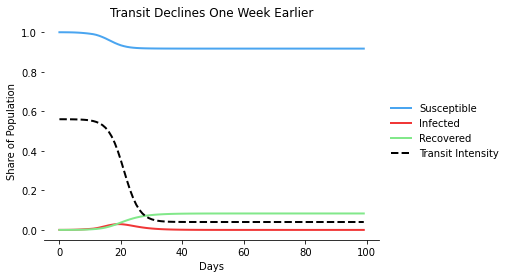

In [64]:
# Limiting travel begins one week earlier
plot_title = 'Transit_Declines_One_Week_Earlier'
ptv = gen_log_ptv(inflection=21)
args4 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args4)

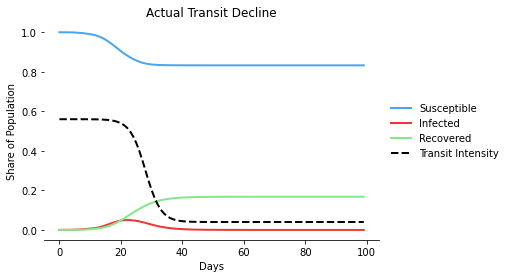

In [65]:
# Actual transit decline
plot_title = 'Actual_Transit_Decline'
ptv = gen_log_ptv()
args4 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args4)

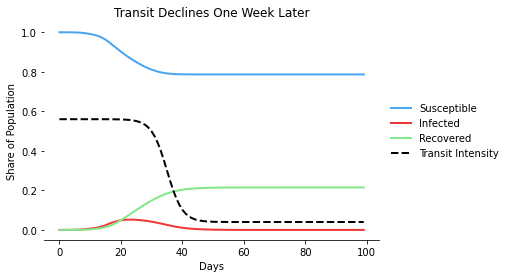

In [66]:
# Limiting travel begins one week earlier
plot_title = 'Transit_Declines_One_Week_Later'
ptv = gen_log_ptv(inflection=35)
args4 = parser.parse_args(f'--public-trans-vec {ptv} --plot-title {plot_title}'.split())
covid_sim(args4)

### Experiment 4: restrictions are lifted on May 15th and transit level increases 

In [ ]:
# NYC reopens, transit goes to 0.28
ptv = generate_ptv(public_trans=0.56, reopen_val=0.28, scenario=3)
args3 = parser.parse_args(f'--public-trans-vec {ptv}'.split())
covid_sim(args3)

NYC reopens, transit goes to 0.56


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.74it/s]


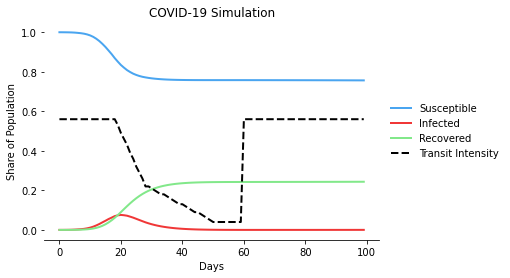

In [81]:
# NYC reopens, transit goes to 0.56
ptv = generate_ptv(public_trans=0.56, reopen_val=0.56, scenario=3)
args3 = parser.parse_args(f'--public-trans-vec {ptv}'.split())
covid_sim(args3)

In [ ]:
# public_trans starts at 1
ptv = generate_ptv(public_trans=1, low_val=0.07, scenario=2)
args2 = parser.parse_args(f'--public-trans-vec {ptv}'.split())
covid_sim(args2)

### Lifting stay-at-home restrictions 
Next, we can simulate the effects of NYC re-opening. In order to do this, we need to set both a date for
the lifting of travel restrictions, and estimate how public transportation will be re-adopted over time.
The current stay-at-home restrictions expire on May 15th, so we can use this as the day public_trans begins
to increase. Exactly how much it will increase by is difficult to predict, so we must speculate. <br> <br>
Even with restrictions lifted, MTA ridership will likely be much lower than usual for quite some time 
due to lingering concern over the virus. Essential workers make up about 25% of the working population, 
and 55% of essential workers rely on public transportation. These figures suggest that 13.75% of the working 
population are estimated to rely on public transportation. However, we know that MTA ridership has dropped 
to about half of this figure (7%). We can speculate that about half of non-essential workers will also refrain 
from using public transportation in the short-term. This suggests that about 28% of the population will utilize 
public transportation in the short-term, after restrictions are lifted. <br>
<br>
#### Timeline
Day &emsp; Ridership <br>
1 &emsp;&emsp;&nbsp;  100% <br>
19 &emsp;&emsp;100% (March 7th -- state of emergency declared -- this is when ridership likely started falling) <br>
29 &emsp;&emsp; 40% (March 17th) <br>
51 &emsp;&emsp; 8%  (Aprile 8th) <br>
60 &emsp;&emsp; 7%  (April 17th) <br>
88 &emsp;&emsp; 28%  (May 15th -- possible lifting of stay-at-home restrictions) <br>

### -Different starting infect_pcts

### -Some % able to get infected twice

### Smoothed public_trans_vec function with logistic curve:

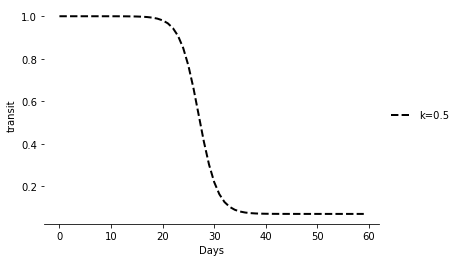

In [200]:
R_0_start, k, x0, R_0_end = .56, 0.5, 27, 0.07*.56

def gen_log_ptv(t, k=.55, start_ptv=.56, inflection=27, end_ptv=0.04):
    return (start_ptv-end_ptv) / (1 + np.exp(-k*(-t+inflection))) + end_ptv

t = np.linspace(0, 60, 60)
# r1 = [logistic_R_0(t, 0.5, 29) for t in range(1,101)]
log_ptv = [gen_log_ptv(i, start_ptv=1, end_ptv=0.07) for i in range(len(t))]

fig = plt.figure()
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.plot(np.arange(60), log_ptv, '--', label='k=0.5', color='k', linewidth=2)
ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))
ax.set_xlabel("Days")
ax.set_ylabel("transit")
plt.show()

### Extra Stuff (In Progress)

#### -Look at hist of populations of each zone, and try adjusting thresholds/infect_pct 

https://gothamist.com/news/coronavirus-statistics-tracking-epidemic-new-york

In [ ]:
import pandas as pd
from pathlib import Path
from IPython.display import Image
import pickle 
img_path = Path.cwd()/'figures'
data_path = Path.cwd()/'data'

# create table of NYC cases, hospitalizations, and deaths, all by age group
rates_by_age = pd.read_csv(data_path/'rates_by_age.csv')
rates_by_age['cases_pct'] = (rates_by_age.cases/rates_by_age.cases.sum()).round(3)
rates_by_age['hospitalizations_pct'] = (rates_by_age.hospitalizations/rates_by_age.hospitalizations.sum()).round(3)
rates_by_age['deaths_pct'] = (rates_by_age.deaths/rates_by_age.deaths.sum()).round(3)
rates_by_age = rates_by_age[['age_group','cases','cases_pct','hospitalizations','hospitalizations_pct','deaths','deaths_pct']]
rates_by_age.to_csv(data_path/'rates_by_age.csv')
'''source:      https://www1.nyc.gov/site/doh/covid/covid-19-data.page
   other sites: https://censusreporter.org/profiles/16000US3651000-new-york-ny/
                https://www.baruch.cuny.edu/nycdata/population-geography/age_distribution.htm
                
                '''

# read OD matrix with 

In [ ]:
pd.read_pickle('./data/nyc_od.p')
od_df.to_csv('./data/nyc_od_labeled.csv')

In [ ]:
# breakdown of age, race, gender

# breakdown of essential vs non-essential workers
# https://comptroller.nyc.gov/reports/new-york-citys-frontline-workers/
#show how each group is affected proportional to their population

### Simulating death rate
By dividing the population into different age groups, we can more accurately simulate the time until recovery or death, depending on the age of the patient. The chart below contains data on coronavirus deaths by age group in New York city as of April 14th. 
<br>
Source: [https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/)

{{rates_by_age}}

In [28]:
Image(filename=img_path/'NYC_death_by_age.JPG', retina=True) 

NameError: name 'Image' is not defined

In [ ]:
rates_by_age

The share of deaths for each agr

In [ ]:
Image(filename=img_path/'NYC_age_by_county.JPG', retina=True) 